# Graph Coloring - 5 Vertices

Now that we were able to solve a 2x2 graph colouring problem, we decided to expand the problem to 5 qubits and increase the constraints to see how the algorithm performs. For 5 qubits, the graph that we decided to go with was similar to that of a cross i.e<br>
One qubit in the intersection of the cross, and four qubits in the four edges of the cross.<br>

Applying the constraints that no two adjacent nodes can have the same colour, and that the minimum number of colours must be used to colour the graph, we can device the constraints that the centre node (intersection of the cross) must be of one colour (say 0), and the others must all have the other colour (say 1). <br>
So with 5 qubits the output must be - <br>
00100<br>
OR<br>
11011<br>

### Importing Libraries

In [38]:
import boto3
from braket.circuits import Circuit
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
from braket.devices import LocalSimulator
import numpy as np
import math

### Defining Device and Results Folder

In [39]:
aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
# device = AwsDevice('arn:aws:braket:::device/quantum-simulator/amazon/sv1')
device = LocalSimulator()
s3_folder = (f"amazon-braket-1c440ad1b4a7","Simulator")


In [40]:
problem_conditions=[[0,2],[1,2],[3,2],[4,2]]
#Here the index 2 is the central node present on the intersection of the cross
#index 2 has to be of a unique colour and the nodes 0,1,3 and 4 can have the second colour


### Implementing the Oracle Part

In [44]:
oracle_1 = Circuit()

for i in range(len(problem_conditions)):
    oracle_1.cnot(problem_conditions[i][0], 5+i)
    oracle_1.cnot(problem_conditions[i][1], 5+i)
    
oracle_1.ccnot(5,6,9)
oracle_1.ccnot(7,9,10)
oracle_1.ccnot(8,10,11)

oracle_1.cnot(11,12)

oracle_1.ccnot(8,10,11)
oracle_1.ccnot(7,9,10)
oracle_1.ccnot(5,6,9)


for i in range(len(problem_conditions)):
    oracle_1.cnot(problem_conditions[i][0], 5+i)
    oracle_1.cnot(problem_conditions[i][1], 5+i)
    
    
oracle=oracle_1
print(oracle)

T   : |   0   |1|2| 3 | 4 |5|6|7| 8 | 9 |10 |11|12|13|14|
                                                         
q0  : -C---------------------------------C---------------
       |                                 |               
q1  : -|-C-------------------------------|-C-------------
       | |                               | |             
q2  : -|-|-----C-C-C---C-----------------|-|-C--C--C--C--
       | |     | | |   |                 | | |  |  |  |  
q3  : -|-|-C---|-|-|---|---------------C-|-|-|--|--|--|--
       | | |   | | |   |               | | | |  |  |  |  
q4  : -|-|-|-C-|-|-|---|-----------C---|-|-|-|--|--|--|--
       | | | | | | |   |           |   | | | |  |  |  |  
q5  : -X-|-|-|-X-|-|-C-|-----------|-C-|-X-|-X--|--|--|--
         | | |   | | | |           | | |   |    |  |  |  
q6  : ---X-|-|---X-|-C-|-----------|-C-|---X----X--|--|--
           | |     | | |           | | |           |  |  
q7  : -----X-|-----X-|-|-C-------C-|-|-X-----------X--|--
             |

In [45]:
temp=[]
for i in range(32):
    
    temp.append([])
    for j in range(32):
        if(i == j):
            if(i == 31):
                temp[i].append(-1.0)
            else:
                temp[i].append(1.0)
        else:
            temp[i].append(0.0)

custom_gate = np.array(temp)

amplify = Circuit()

amplify.h([0,1,2,3,4])
amplify.x([0,1,2,3,4]).unitary(matrix=custom_gate, targets=[0,1,2,3,4]).x([0,1,2,3,4])
amplify.h([0,1,2,3,4])

print(amplify)

T  : |0|1|2|3|4|
                
q0 : -H-X-U-X-H-
          |     
q1 : -H-X-U-X-H-
          |     
q2 : -H-X-U-X-H-
          |     
q3 : -H-X-U-X-H-
          |     
q4 : -H-X-U-X-H-

T  : |0|1|2|3|4|


In [46]:
# Sudoku Solver

sudoku = Circuit()
sudoku.x([12]).h([0,1,2,3,4,12])
for i in range(1):
    sudoku.add(oracle)
    sudoku.add(amplify)
print(sudoku)



T   : |0|   1   |2|3| 4 | 5 |6|7|8| 9 |10 | 11  |12 |13|14|15|16|17|18|19|20|
                                                                             
q0  : -H-C---------------------------------C-----H---X--------------U--X--H--
         |                                 |                        |        
q1  : -H-|-C-------------------------------|-C---H---X--------------U--X--H--
         | |                               | |                      |        
q2  : -H-|-|-----C-C-C---C-----------------|-|---C---C--C--C--H--X--U--X--H--
         | |     | | |   |                 | |   |   |  |  |        |        
q3  : -H-|-|-C---|-|-|---|---------------C-|-|-H-|-X-|--|--|--------U--X--H--
         | | |   | | |   |               | | |   |   |  |  |        |        
q4  : -H-|-|-|-C-|-|-|---|-----------C-H-|-|-|-X-|---|--|--|--------U--X--H--
         | | | | | | |   |           |   | | |   |   |  |  |                 
q5  : ---X-|-|-|-X-|-|-C-|-----------|-C-|-X-|---X---|--|--|----

In [75]:
counts = device.run(sudoku, shots = 1000).result().measurement_counts



In [83]:
solutions=[]
total_times=[]

new=dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
for key, value in new.items():
    
    if(len(solutions)>5):
        break
    if(key[:5] not in solutions):
        solutions.append(key[:5])
        total_times.append(0)
    total_times[solutions.index(key[:5])] += value


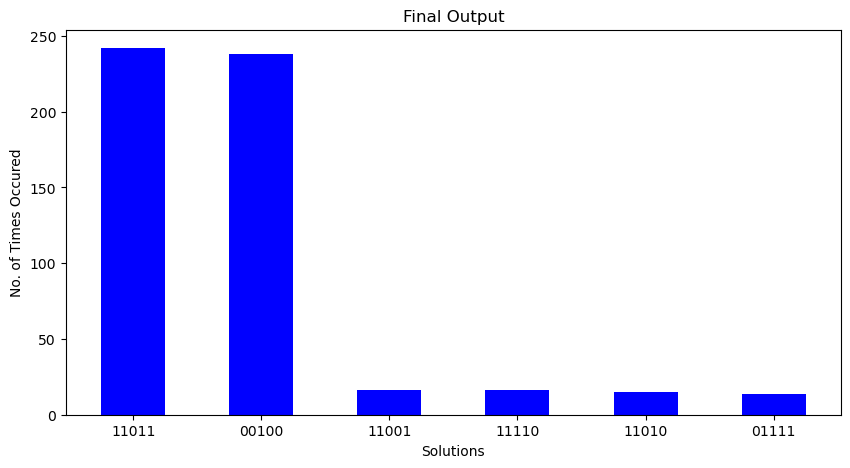

In [84]:

  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(solutions, total_times, color ='blue',
        width = 0.5)
 
plt.xlabel("Solutions")
plt.ylabel("No. of Times Occured")
plt.title("Final Output")
plt.show()

As we see in the graph above, the solutions 11011 and 00100 have overwhelmingly occured the most number of times, consistent with our required solution set. The rest of the solutions are just noise that has been generated during computation.<br><br>
Consider the below colouring pattern where Red is denoted by 0 and Yellow is denoted by 1.

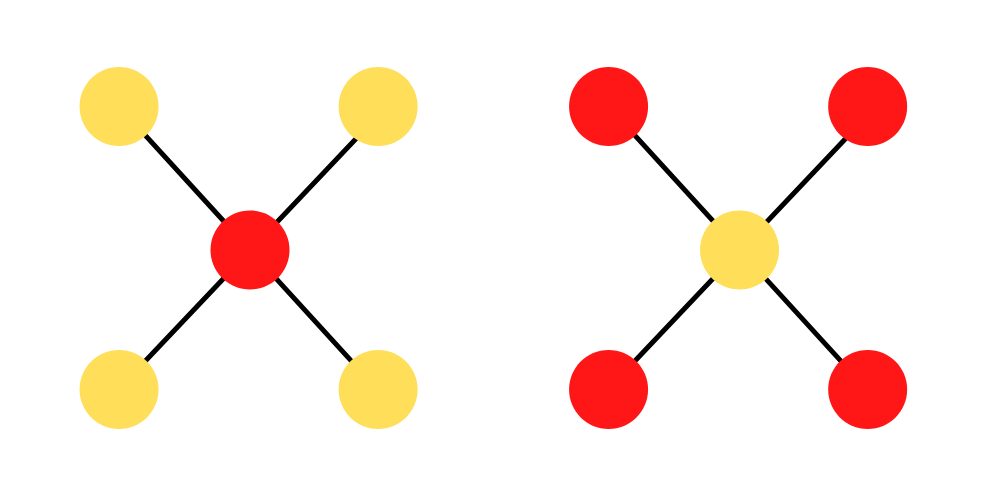